In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
import datetime as dt 
# dt as time_series operation
%matplotlib inline
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# storage
from google.datalab import Context
import google.datalab.bigquery as bq
try:
  from StringIO import StringIO
except ImportError:
  from io import BytesIO as StringIO
# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# IO

In [2]:
!pip install xgboost

In [3]:
import xgboost as xgb

In [4]:
xgb.__version__

'0.6'

In [5]:
%gcs read --object gs://kkbox_bucket/ft_satisfaction.csv -v df_ft_satis

In [6]:
df_ft_satis = pd.read_csv(StringIO(df_ft_satis))

In [7]:
%gcs read --object gs://kkbox_bucket/ft_day_listen.csv -v df_ft_day_listen

In [8]:
df_ft_day_listen = pd.read_csv(StringIO(df_ft_day_listen))
df_train = pd.merge(df_ft_day_listen, df_ft_satis, how='left',on=['msno'])

In [9]:
%gcs read --object gs://kkbox_bucket/sub_ft_satisfaction.csv -v df_sub_ft_satis

In [10]:
%gcs read --object gs://kkbox_bucket/sub_ft_day_listen.csv -v df_sub_ft_day_listen

In [11]:
df_sub_ft_day_listen = pd.read_csv(StringIO(df_sub_ft_day_listen))
df_sub_ft_satis = pd.read_csv(StringIO(df_sub_ft_satis))
df_sub = pd.merge(df_sub_ft_day_listen, df_sub_ft_satis, how='left',on=['msno'])

df_sub.is_churn = np.nan

In [12]:
%gcs read --object gs://kkbox_bucket/members_v3.csv -v members

In [13]:
df_members =pd.read_csv(StringIO(members))

In [14]:
df_data = df_train.append(df_sub)
df_data = pd.merge(df_data, df_members, how='left',on=['msno'])
gender_encode = {'male':1, 'female':2}
df_data.gender = df_data.gender.map(gender_encode)
# change feature name
df_data = df_data.rename(columns={'day_listen':'six_month_day_listen','user_latent_satisfaction':'six_month_satis'})
# missing value 
print('-'*10,'missing value summary','-'*10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df_data.isnull().sum() / len(df_data))

---------- missing value summary ----------
msno                     0.000
is_churn                 0.523
six_month_day_listen     0.167
six_month_satis          0.167
city                     0.118
bd                       0.118
gender                   0.620
registered_via           0.118
registration_init_time   0.118
dtype: float64


In [15]:
df_data.head()

,msno,is_churn,six_month_day_listen,six_month_satis,city,bd,gender,registered_via,registration_init_time
0,2wJJToqAXFTdG1wP8qmQhsv6dJlj4Jr4ZCFhp0ZEVVI=,0.000,135.000,0.732,22.000,29.000,1.000,3.000,20150926.000
1,3/jv0QbKYn+W+bhSA9ZaMgHv9fpYivo2aiP8hIJPfUQ=,0.000,137.000,0.613,13.000,43.000,2.000,7.000,20120203.000
2,6nyAb4oFlm2yQ7XooMqjwSY+BJhRHN8VCRl2dgf3+fA=,0.000,38.000,0.884,6.000,38.000,1.000,7.000,20160302.000
3,BtQP2kyMWYmfyiXjttWNoqygnb2hMhN6qbZ8cGo9pD0=,0.000,103.000,0.839,14.000,47.000,1.000,9.000,20080723.000
4,CRrNBvDX9zkRTWsKlr8AyWKCCRynsqPW6ptSdnBCXTQ=,0.000,55.000,0.864,1.000,0.000,nan,7.000,20160208.000


# Member features

## Registered_via

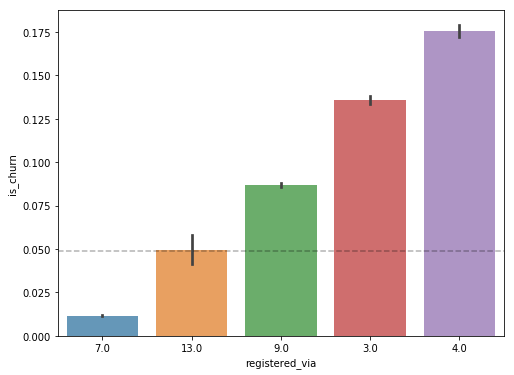

In [16]:
# aggregate result in order to sort 
result_reg = df_data.groupby(["registered_via"])['is_churn'].mean().reset_index().sort_values('is_churn')
# make plot
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='registered_via',y='is_churn',data=df_data,order=result_reg['registered_via'],ax=ax,alpha=.75)
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

In [17]:
df_data.registered_via = df_data.registered_via.fillna(-1)
df_data.six_month_day_listen = df_data.six_month_day_listen.fillna(-1)
df_data.six_month_satis = df_data.six_month_satis.fillna(-1)

### Modeling

In [18]:
def model_training_rf(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state = 2)
  # Training ~ 01:45s
  model = RandomForestClassifier(random_state=2,n_estimators=300,
                           min_samples_split=0.05,n_jobs=-1,class_weight={0 :0.45,1 :0.55})
  model.fit(X_train,Y_train)
  
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [19]:
def model_training_xgb(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # model
  xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=4,n_estimators=300,\
                 subsample=0.5, seed=2,missing=-1)
  model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [20]:
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
reg_via_fts = ['msno','is_churn','six_month_day_listen', 'six_month_satis','registered_via']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')


In [21]:
reg_via_model, reg_via_val_score,\
reg_via_pred = model_training_rf(df_train[reg_via_fts],df_sub[reg_via_fts])

In [22]:
reg_via_model_xgb, reg_via_val_score_xgb,\
reg_via_pred_xgb = model_training_xgb(df_train[reg_via_fts],df_sub[reg_via_fts])

[0]	validation_0-logloss:0.629569	validation_1-logloss:0.629518
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.165437	validation_1-logloss:0.164247
Stopping. Best iteration:
[114]	validation_0-logloss:0.165098	validation_1-logloss:0.164136



In [23]:
print('day_listen + user_letent_satisfaction logloss val: ',0.192158)
print('reg_via log_loss val xgb: ',np.around(reg_via_val_score_xgb,decimals=6))
print('reg_via log_loss val rf: ',np.around(reg_via_val_score,decimals=6))
print('-'*20,'LB','-'*20)
print('reg_via log_loss LB : ',0.13264)

day_listen + user_letent_satisfaction logloss val:  0.192158
reg_via log_loss val xgb:  0.164161
reg_via log_loss val rf:  0.167638
-------------------- LB --------------------
reg_via log_loss LB :  0.13264


In [24]:
reg_via_pred_xgb.to_csv("/content/datalab/sub_reg_via_xgb_pred.csv", index=False)

In [25]:
!gsutil cp '/content/datalab/sub_reg_via_xgb_pred.csv' 'gs://kkbox_bucket/submission/sub_reg_via_xgb_pred.csv';

Copying file:///content/datalab/sub_reg_via_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 52.5 MiB/ 52.5 MiB]                                                
Operation completed over 1 objects/52.5 MiB.                                     


## Age

In [26]:
display(df_data[['bd']].describe())
# how many % of meanful values? 
meaningful = (df_data.bd > 0 ) & (df_data.bd < 90)
print('Ages between 0 ~ 90   :  %.3f   ' %( len(df_data[meaningful]) / len(df_data) ))

,bd
count,1638718.000
mean,12.929
std,19.623
min,-3152.000
25%,0.000
50%,0.000
75%,27.000
max,2016.000


Ages between 0 ~ 90   :  0.377   


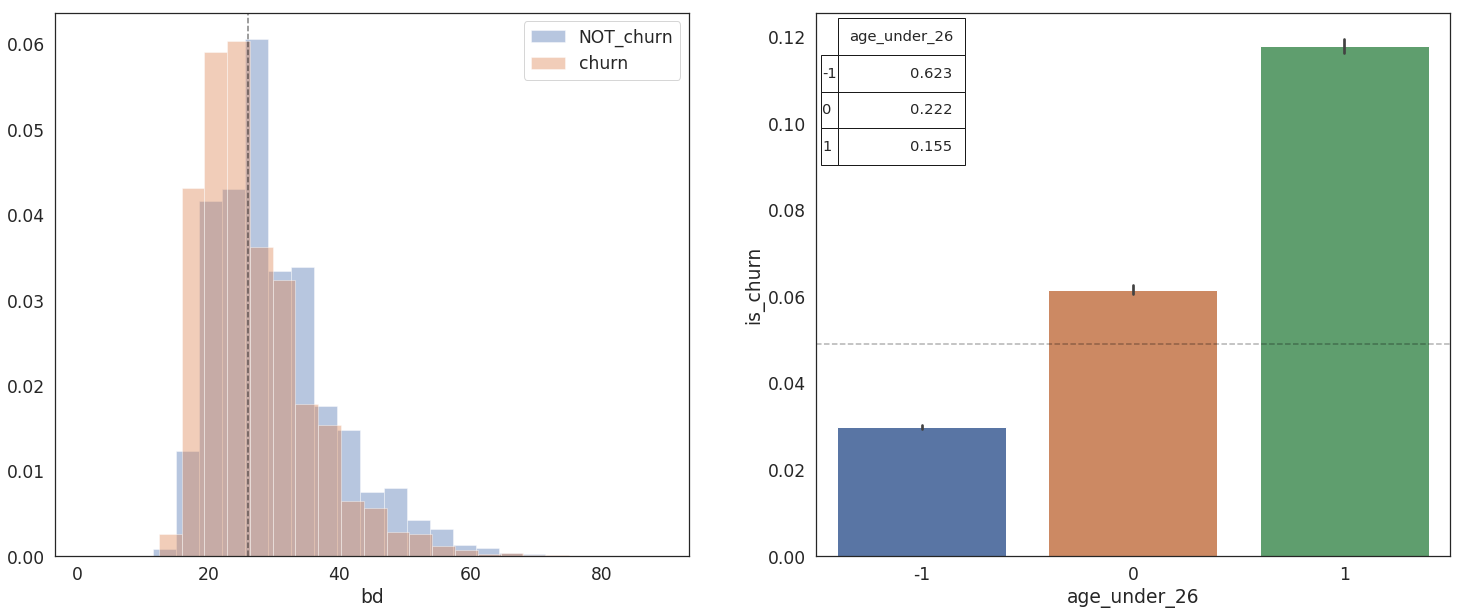

In [27]:
sns.set(font_scale=1.56)
from pandas.plotting import table

# create fig and ax 
with sns.axes_style('white'):

    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(25,10))
# distribution
    NOT_churn = ( (df_data.is_churn == 0) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    churn = ( (df_data.is_churn == 1) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    bins= 25
    sns.distplot(df_data.loc[NOT_churn,'bd'],kde=False,label='NOT_churn',ax=ax1,norm_hist=True,bins=bins)
    sns.distplot(df_data.loc[churn,'bd'],kde=False,label='churn',ax=ax1,norm_hist=True,bins=bins)
    ax1.legend()
    ax1.axvline(26,linestyle='dashed',c='black',alpha=.5)

# feature engineering
# create feature  bd<26 == 1, bd>26 ==0 , other = -1
    condition = df_data.bd < 26
    df_data['age_under_26'] = df_data.bd.apply(lambda x: 1 if 0 < x <= 26 else 0 if 26 < x <= 90 else -1)

# prepare table (% of each value)
    df_percent = pd.DataFrame( df_data['age_under_26'].value_counts().sort_index() / len(df_data) ).round(3) 
# barplot with percent table
    sns.barplot(x='age_under_26',y='is_churn',data=df_data,ax=ax2)
    ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
    table(ax2, df_percent,bbox=[0.035, 0.72, 0.2, 0.27])

### Modeling

In [28]:
# split and prepare features 
df_train = df_data[:len(df_train)]
df_sub = df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
age_fts = reg_via_fts + ['age_under_26']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26'],
      dtype='object')


In [29]:
print('training using features:' ,[fts for fts in age_fts if fts not in exclude_list])
age_model_xgb, age_val_score_xgb,\
age_pred_xgb = model_training_xgb(df_train[age_fts],df_sub[age_fts])

training using features: ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26']
[0]	validation_0-logloss:0.629497	validation_1-logloss:0.629427
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.163293	validation_1-logloss:0.161943
Stopping. Best iteration:
[110]	validation_0-logloss:0.162894	validation_1-logloss:0.161732



In [30]:
age_pred_xgb.to_csv("/content/datalab/sub_age_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_age_xgb_pred.csv' 'gs://kkbox_bucket/submission/sub_age_xgb_pred.csv';

print('reg_via logloss val: ',0.164043)
print('reg_via logloss LB: ',0.13264)
print('-'*20,' + age','-'*20)
print('age log_loss LB : ',0.161515)
print('age log_loss LB : ',0.13161)

Copying file:///content/datalab/sub_age_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 52.5 MiB/ 52.5 MiB]                                                
Operation completed over 1 objects/52.5 MiB.                                     
reg_via logloss val:  0.164043
reg_via logloss LB:  0.13264
--------------------  + age --------------------
age log_loss LB :  0.161515
age log_loss LB :  0.13161


# Transactions features
## IO

In [31]:
# first time you for merging data
%gcs read --object gs://kkbox_bucket/transactions.csv -v trans

%gcs read --object gs://kkbox_bucket/transactions_v2.csv -v trans_v2

%time
df_trans = pd.read_csv(StringIO(trans))
df_trans_v2 = pd.read_csv(StringIO(trans_v2))
df_trans_all = pd.concat([df_trans,df_trans_v2])
df_train_trans = pd.merge(df_train[['msno','is_churn']],df_trans_all,how='left',on=['msno'])
df_sub_trans = pd.merge(df_sub[['msno','is_churn']],df_trans_all,how='left',on=['msno'])

df_train_trans.to_csv("/content/datalab/df_train_trans_merged.csv", index=False)
!gsutil cp '/content/datalab/df_train_trans_merged.csv' 'gs://kkbox_bucket/df_train_trans_merged.csv';

df_sub_trans.to_csv("/content/datalab/df_sub_trans_merged.csv", index=False)
!gsutil cp '/content/datalab/df_sub_trans_merged.csv' 'gs://kkbox_bucket/df_sub_trans_merged.csv';


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs
Copying file:///content/datalab/df_train_trans_merged.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][  1.2 GiB/  1.2 GiB]                                                
Operation completed over 1 objects/1.2 GiB.                                      
Co

In [32]:
%gcs read --object gs://kkbox_bucket/df_train_trans_merged.csv -v trans

In [33]:
%gcs read --object gs://kkbox_bucket/df_sub_trans_merged.csv -v sub_trans

In [34]:
%time
df_train_trans = pd.read_csv(StringIO(trans))
df_sub_trans = pd.read_csv(StringIO(sub_trans))

CPU times: user 33.4 s, sys: 3.95 s, total: 37.3 s
Wall time: 37.3 s


In [35]:
df_train_trans.shape, df_sub_trans.shape

((14622996, 10), (16255622, 10))

In [36]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [37]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y%m%d') for date in s.unique()}
    return s.map(dates)

In [38]:
# rename the columns
date_rename = {'transaction_date':'trans_date', 'membership_expire_date':'mem_expire_date'}
df_train_trans.rename(columns=date_rename,inplace=True)
df_sub_trans.rename(columns=date_rename,inplace=True)

# converting
df_train_trans = dtype_compressor(df_train_trans)
df_sub_trans = dtype_compressor(df_sub_trans)
# 1 mins 40 s (with apply approach)
# vectorlized 15s
d = ['trans_date', 'mem_expire_date']
for col in d:
  df_train_trans[col] = fast_datetime(df_train_trans[col])
  df_sub_trans[col] = fast_datetime(df_sub_trans[col])
# took 6s 
# total about 20~30s for single dataframe

In [39]:
df_sub_trans.is_churn = np.NaN
print("Traning_set missing:\n",np.around(df_train_trans.isnull().sum() / df_train_trans.shape[0],decimals=3))
print(''*60)
print("_"*60)
print(''*60)
print("Testing_set missing:\n",np.around(df_sub_trans.isnull().sum() / df_sub_trans.shape[0],decimals=3))
# no missing value! we can use trasactions table to filling members (12.3%), uerlogs (23%)

Traning_set missing:
 msno                 0.000
is_churn             0.000
payment_method_id    0.000
payment_plan_days    0.000
plan_list_price      0.000
actual_amount_paid   0.000
is_auto_renew        0.000
trans_date           0.000
mem_expire_date      0.000
is_cancel            0.000
dtype: float64

____________________________________________________________

Testing_set missing:
 msno                 0.000
is_churn             1.000
payment_method_id    0.000
payment_plan_days    0.000
plan_list_price      0.000
actual_amount_paid   0.000
is_auto_renew        0.000
trans_date           0.000
mem_expire_date      0.000
is_cancel            0.000
dtype: float64


## Glance at transactions

In [40]:
# sort first for easier exploration
df_train_trans = df_train_trans.sort_values(by=['msno','trans_date'])
df_sub_trans = df_sub_trans.sort_values(by=['msno','trans_date'])
df_train_trans.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,trans_date,mem_expire_date,is_cancel
5700634,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2016-11-16,2016-12-15,0
5700636,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2016-12-15,2017-01-15,0
5700633,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-01-15,2017-02-15,0
5700635,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-02-15,2017-03-15,0
5700637,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0,41,30,99,99,1,2017-03-15,2017-04-15,0


## Preprocessing
### Date Outlier

In [41]:
# sort first for easier exploration
df_train_trans = df_train_trans.sort_values(by=['msno','trans_date'])
df_sub_trans = df_sub_trans.sort_values(by=['msno','trans_date'])

# build membership
df_train_trans = df_train_trans.eval('membership = mem_expire_date - trans_date')
df_sub_trans = df_sub_trans.eval('membership = mem_expire_date - trans_date')

# now vectorlized
df_train_trans['membership_int'] = df_train_trans.membership / np.timedelta64(1,'D')
df_sub_trans['membership_int'] = df_sub_trans.membership / np.timedelta64(1,'D')


# glance 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display_side_by_side(df_train_trans[['membership_int','payment_plan_days']].describe(),\
                    df_sub_trans[['membership_int','payment_plan_days']].describe())

,membership_int,payment_plan_days
count,14622996.000,14622996.000
mean,36.552,30.071
std,85.576,18.187
min,-17217.000,0.000
25%,30.000,30.000
50%,31.000,30.000
75%,31.000,30.000
max,2796.000,450.000
,membership_int,payment_plan_days
count,16255622.000,16255622.000


In [42]:
# Summarization
print("_"*15," (the training set) df_train_trans ", "_"*15)
print(''*60)
print("_"*30," < -30 days", "_"*30)
print('is_cancel = 0')
min_date = df_train_trans.membership_int.min()
con = ((df_train_trans.membership_int.between(min_date, -30)) & (df_train_trans.is_cancel == 0))
print(''*60)
print(df_train_trans.loc[con,'payment_plan_days'].value_counts().sort_index())
are_0_plan_days = df_train_trans.payment_plan_days.isin([0])
print(''*60)
print("is_cancel = 0 , plan_days = 0" ) 
print(df_train_trans.loc[con & are_0_plan_days, 'actual_amount_paid'].value_counts().sort_index())
# 1449 means 30 days plan , only 1 paid zero, place 30 days also
print(''*60)
print("_"*30," > 450 days", "_"*30)
print('is_cancel = 0')
print(''*60)
print(df_train_trans.loc[df_train_trans.membership > pd.Timedelta('450 days'), 'payment_plan_days'].value_counts().sort_index())
print(''*60)
print('is_cancel = 0 & plan_days = 0')
print(''*60)
con = (df_train_trans.payment_plan_days == 0) & (df_train_trans.membership_int > 450)
print(df_train_trans.loc[con, 'actual_amount_paid'].value_counts().sort_index())
# 100,119,129,149 --> 30days 
#1599.1788 --> 400 days

_______________  (the training set) df_train_trans  _______________

______________________________  < -30 days ______________________________
is_cancel = 0

0       179
30     1184
60       74
120       6
180       6
240      12
Name: payment_plan_days, dtype: int64

is_cancel = 0 , plan_days = 0
0        1
149    178
Name: actual_amount_paid, dtype: int64

______________________________  > 450 days ______________________________
is_cancel = 0

0       3207
1         12
10         2
14         1
30     74547
90         1
180        3
195        2
360       14
365        2
395      142
400        9
410      108
450       75
Name: payment_plan_days, dtype: int64

is_cancel = 0 & plan_days = 0

100       17
119      252
129      268
149     2657
1599      11
1788       2
Name: actual_amount_paid, dtype: int64


In [43]:
def fast_time_delta(s):
    intervals = {interval:pd.to_timedelta(interval,unit='D') for interval in s.unique()}
    return s.map(intervals)

# ------------------------------------------negtive min_date ~ -30 days-------------------------------------------------------------
# is_cancel = 1
  # Clean up by replaceing trans_date 
min_date = df_train_trans.membership_int.min()
con = ((df_train_trans.membership_int.between(min_date, -30)) & (df_train_trans.is_cancel == 1))
df_train_trans.loc[con, 'mem_expire_date'] = df_train_trans.loc[con, 'trans_date'] 
# is_cancel = 0
  # Clean up use:
    # engineered payment_plan_days_time_delta --> plan_days_td
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0  --> expire = trans + 30 days (explored first with actual_amount_paid)
    # the actual_amount_paid could be check on Summarization above

df_train_trans['plan_days_td'] = fast_time_delta(df_train_trans.payment_plan_days)


  # not_0_plan_days
con = ((df_train_trans.membership_int.between(min_date,-30)) & (df_train_trans.is_cancel == 0))
not_0_plan_days = ~ (df_train_trans.payment_plan_days.isin([0]))
df_train_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_train_trans.loc[con & not_0_plan_days,'plan_days_td']

  # are_0_plan_days
are_0_plan_days = df_train_trans.payment_plan_days.isin([0])
df_train_trans.loc[con & are_0_plan_days,'mem_expire_date'] = df_train_trans.loc[con & are_0_plan_days,'trans_date'] + pd.Timedelta('30 days')

#  -----------------------------------------positive 450 days ~ max_date-------------------------------------------------------------


# is_cancel = 1
  # Clean up by replaceing trans_date 
max_date = df_train_trans.membership_int.max()
con = ((df_train_trans.membership_int.between(450, max_date)) & (df_train_trans.is_cancel == 1))
df_train_trans.loc[con, 'mem_expire_date'] = df_train_trans.loc[con, 'trans_date'] 

# is_cancel = 0
  # Clean up use:
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0 
      # the  30 days case --> expire = trans + 30 days
      # the 400 days case --> expire = trnas + 400 days


# payment_plan_day not 0
con = ((df_train_trans.membership_int.between(450,max_date)) & (df_train_trans.is_cancel == 0))
not_0_plan_days = ~ (df_train_trans.payment_plan_days.isin([0]))
df_train_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_train_trans.loc[con & not_0_plan_days,'plan_days_td']

# plan_days = 0 infer by actual_amount_paid
# the 30 days case

con = (df_train_trans.payment_plan_days == 0) & (df_train_trans.membership_int > 450)

paid_30_days = df_train_trans.actual_amount_paid.isin([100,119,129,149])
df_train_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
df_train_trans.loc[con & paid_30_days, 'trans_date'] + pd.Timedelta('30 days')

# plan_days = 0 infer by actual_amount_paid
# the 400 days case
paid_400_days = df_train_trans.actual_amount_paid.isin([1599,1788])
df_train_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
df_train_trans.loc[con & paid_400_days, 'trans_date'] + pd.Timedelta('400 days')

In [44]:
# Summirization
print("_"*15," (the testing set) df_sub_trans ", "_"*15)
print(''*60)
print("_"*30," < -30 days", "_"*30)
print('is_cancel = 0')
min_date = df_sub_trans.membership_int.min()
con = ((df_sub_trans.membership_int.between(min_date, -30)) & (df_sub_trans.is_cancel == 0))
print(''*60)
print(df_sub_trans.loc[con,'payment_plan_days'].value_counts().sort_index())
are_0_plan_days = df_sub_trans.payment_plan_days.isin([0])
print(''*60)
print("is_cancel = 0 , plan_days = 0" ) 
print(df_sub_trans.loc[con & are_0_plan_days, 'actual_amount_paid'].value_counts().sort_index())
# 1449 means 30 days plan , only 1 paid zero, place 30 days also
print(''*60)
print("_"*30," > 450 days", "_"*30)
print('is_cancel = 0')
print(''*60)
print(df_sub_trans.loc[df_sub_trans.membership > pd.Timedelta('450 days'), 'payment_plan_days'].value_counts().sort_index())
print(''*60)
print('is_cancel = 0 & plan_days = 0')
print(''*60)
con = (df_sub_trans.payment_plan_days == 0) & (df_sub_trans.membership_int > 450)
print(df_sub_trans.loc[con, 'actual_amount_paid'].value_counts().sort_index())
# 100,119,129,149 --> 30days 
#1599.1788 --> 400 days

_______________  (the testing set) df_sub_trans  _______________

______________________________  < -30 days ______________________________
is_cancel = 0

0       183
30     1212
60      175
120      12
180       6
240      11
Name: payment_plan_days, dtype: int64

is_cancel = 0 , plan_days = 0
0        1
149    182
Name: actual_amount_paid, dtype: int64

______________________________  > 450 days ______________________________
is_cancel = 0

0        4810
1          24
3           1
7         958
10        287
21          6
30     111177
31         15
35         12
60          3
70          1
90         30
100         5
120        30
180        31
195        15
200        13
230         1
240         1
270         1
360        53
365        71
395       363
400        18
410       290
415         6
450        92
Name: payment_plan_days, dtype: int64

is_cancel = 0 & plan_days = 0

0          2
100       24
119      369
129      367
149     4033
1599      13
1788       2
Name: actual_a

In [45]:
# ------------------------------------------negtive min_date ~ -30 days-------------------------------------------------------------
# is_cancel = 1
  # Clean up by replaceing trans_date 
min_date = df_sub_trans.membership_int.min()
con = ((df_sub_trans.membership_int.between(min_date, -30)) & (df_sub_trans.is_cancel == 1))
df_sub_trans.loc[con, 'mem_expire_date'] = df_sub_trans.loc[con, 'trans_date'] 
# is_cancel = 0
  # Clean up use:
    # engineered payment_plan_days_time_delta --> plan_days_td
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0  --> expire = trans + 30 days (explored first with actual_amount_paid)
    # the actual_amount_paid could be check on Summirization above

df_sub_trans['plan_days_td'] = fast_time_delta(df_sub_trans.payment_plan_days)


  # not_0_plan_days
con = ((df_sub_trans.membership_int.between(min_date,-30)) & (df_sub_trans.is_cancel == 0))
not_0_plan_days = ~ (df_sub_trans.payment_plan_days.isin([0]))
df_sub_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_sub_trans.loc[con & not_0_plan_days,'plan_days_td']

  # are_0_plan_days
  # the only one record paid 0 just fill with 30 days treated as NOISE
are_0_plan_days = df_sub_trans.payment_plan_days.isin([0])
df_sub_trans.loc[con & are_0_plan_days,'mem_expire_date'] = df_sub_trans.loc[con & are_0_plan_days,'trans_date'] + pd.Timedelta('30 days')

#  -----------------------------------------positive 450 days ~ max_date-------------------------------------------------------------


# is_cancel = 1
  # Clean up by replaceing trans_date 
max_date = df_sub_trans.membership_int.max()
con = ((df_sub_trans.membership_int.between(450, max_date)) & (df_sub_trans.is_cancel == 1))
df_sub_trans.loc[con, 'mem_expire_date'] = df_sub_trans.loc[con, 'trans_date'] 

# is_cancel = 0
  # Clean up use:
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0 
      # the  30 days case --> expire = trans + 30 days
      # the 400 days case --> expire = trnas + 400 days


# payment_plan_day not 0
con = ((df_sub_trans.membership_int.between(450,max_date)) & (df_sub_trans.is_cancel == 0))
not_0_plan_days = ~ (df_sub_trans.payment_plan_days.isin([0]))
df_sub_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_sub_trans.loc[con & not_0_plan_days,'plan_days_td']

# plan_days = 0 infer by actual_amount_paid
# the 30 days case

con = (df_sub_trans.payment_plan_days == 0) & (df_sub_trans.membership_int > 450)

paid_30_days = df_sub_trans.actual_amount_paid.isin([100,119,129,149])
df_sub_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
df_sub_trans.loc[con & paid_30_days, 'trans_date'] + pd.Timedelta('30 days')

# plan_days = 0 infer by actual_amount_paid
# the 400 days case
paid_400_days = df_sub_trans.actual_amount_paid.isin([1599])
df_sub_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
df_sub_trans.loc[con & paid_400_days, 'trans_date'] + pd.Timedelta('400 days')

### Drop leaky predictor

In [46]:
print(df_train_trans[df_train_trans.trans_date > np.datetime64('2017-03-01')].shape)
print(df_sub_trans[df_sub_trans.trans_date > np.datetime64('2017-04-01')].shape)

(853747, 13)
(0, 13)


In [47]:
df_train_trans = df_train_trans[ ~ (  df_train_trans.trans_date > np.datetime64('2017-03-01')  ) ]
df_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13769249 entries, 5700634 to 13027578
Data columns (total 13 columns):
msno                  category
is_churn              int8
payment_method_id     int8
payment_plan_days     int16
plan_list_price       int16
actual_amount_paid    int16
is_auto_renew         int8
trans_date            datetime64[ns]
mem_expire_date       datetime64[ns]
is_cancel             int8
membership            timedelta64[ns]
membership_int        float64
plan_days_td          timedelta64[ns]
dtypes: category(1), datetime64[ns](2), float64(1), int16(3), int8(4), timedelta64[ns](2)
memory usage: 860.9 MB


## Features
### Last_Last_churn

In [48]:
def ll_churn(df):
  # to avoid mistake by chance, let's sort first
  # at the same time, groupby.cumsum has no argument about ascending, so it's necessary
  
  df = df.sort_values(by=['msno','trans_date'],ascending=True)
  df['next_trans_after'] = df['trans_date'].shift(-1) - df['mem_expire_date']
  df['the_same_user'] = df['msno'] == df['msno'].shift(-1)
  
  # 40 days allow more tolerance about churn
  df['churn_record'] = (df['next_trans_after'] > pd.Timedelta('30 days')) & (df['the_same_user'] == True)
  
  # convert boolen to 1 and 0 
  df['churn_record'] = df['churn_record']*1
  
  # sort_by expire_date
  df = df.sort_values(by=['msno','mem_expire_date'],ascending=False)

  # take out last_last_churn
  ft = df.groupby(by=['msno'],as_index=False).nth(1)[['msno','churn_record']]
  ft = ft.rename(columns={'churn_record':'last_last_churn'})
  
  return ft

In [49]:
ft_last_last_churn_train = ll_churn(df_train_trans)
ft_last_last_churn_sub = ll_churn(df_sub_trans)

In [50]:
df_train = pd.merge(df_train,ft_last_last_churn_train,how='left',on=['msno']);
df_sub = pd.merge(df_sub,ft_last_last_churn_train,how='left',on=['msno']);

In [51]:
# only one trans_record does not have last_last_churn information
df_train.last_last_churn = df_train.last_last_churn.fillna(-1)
df_sub.last_last_churn = df_sub.last_last_churn.fillna(-1)
print('_'*30, 'traning set', '_'*30)
print(''*60)
print(df_train.last_last_churn.value_counts())
print('_'*30, 'testing set', '_'*30)
print(''*60)
print(df_sub.last_last_churn.value_counts())

______________________________ traning set ______________________________

0.000     839107
-1.000     36788
1.000      10605
Name: last_last_churn, dtype: int64
______________________________ testing set ______________________________

0.000     815656
-1.000    145043
1.000      10261
Name: last_last_churn, dtype: int64


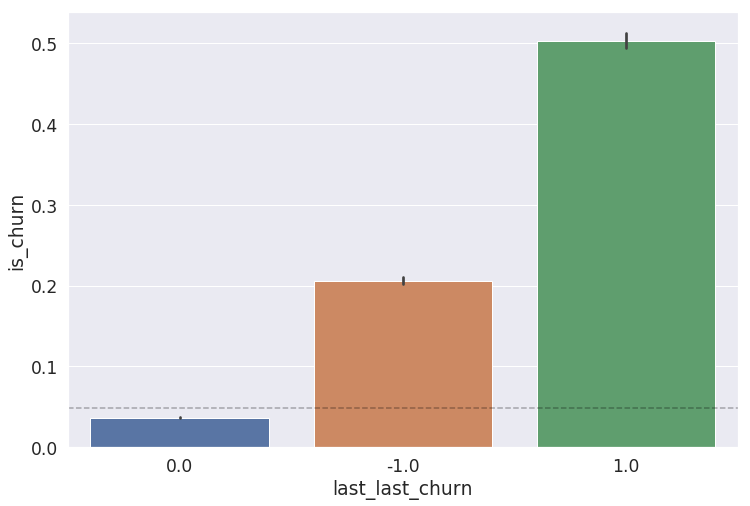

In [52]:
result_ll_churn = df_train.groupby(["last_last_churn"])['is_churn'].mean().reset_index().sort_values('is_churn')
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='last_last_churn', y='is_churn', data=df_train,ax=ax,order=result_ll_churn['last_last_churn'])
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

### Modeling

In [53]:
# split and prepare features 
print(df_train.columns)
print(df_sub.columns)
ll_churn_fts = age_fts + ['last_last_churn']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn'],
      dtype='object')


In [54]:
print('training using features: \n' ,[fts for fts in ll_churn_fts if fts not in exclude_list])
ll_churn_model_xgb, ll_churn_val_score_xgb,\
ll_churn_pred_xgb = model_training_xgb(df_train[ll_churn_fts],df_sub[ll_churn_fts])

training using features: 
 ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26', 'last_last_churn']
[0]	validation_0-logloss:0.628825	validation_1-logloss:0.628735
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.155072	validation_1-logloss:0.153403
[140]	validation_0-logloss:0.154408	validation_1-logloss:0.153105
Stopping. Best iteration:
[131]	validation_0-logloss:0.154459	validation_1-logloss:0.153101



In [55]:
ll_churn_pred_xgb.to_csv("/content/datalab/sub_ll_churn_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_ll_churn_xgb_pred.csv' 'gs://kkbox_bucket/submission/sub_ll_churn_xgb_pred.csv';

print('age logloss val: ',0.16151)
print('age logloss LB: ',0.13161)
print('-'*20,' + ll_churn','-'*20)
print('ll_churn log_loss val : ',0.15347)
print('ll_churn log_loss LB : ',0.12698)

Copying file:///content/datalab/sub_ll_churn_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 52.4 MiB/ 52.4 MiB]                                                
Operation completed over 1 objects/52.4 MiB.                                     
age logloss val:  0.16151
age logloss LB:  0.13161
--------------------  + ll_churn --------------------
ll_churn log_loss val :  0.15347
ll_churn log_loss LB :  0.12698


## Trans_times

In [56]:
# Feature Engineering and merge
ft_trans_times_train = df_train_trans[['msno','trans_date']].groupby(by=['msno'],as_index=False).count().\
rename(columns={'trans_date':'trans_times'});
ft_trans_times_sub = df_sub_trans[['msno','trans_date']].groupby(by=['msno'],as_index=False).count().\
rename(columns={'trans_date':'trans_times'});
df_train = pd.merge(df_train, ft_trans_times_train, how='left', on=['msno'])
df_sub = pd.merge(df_sub, ft_trans_times_sub,how='left', on=['msno'])

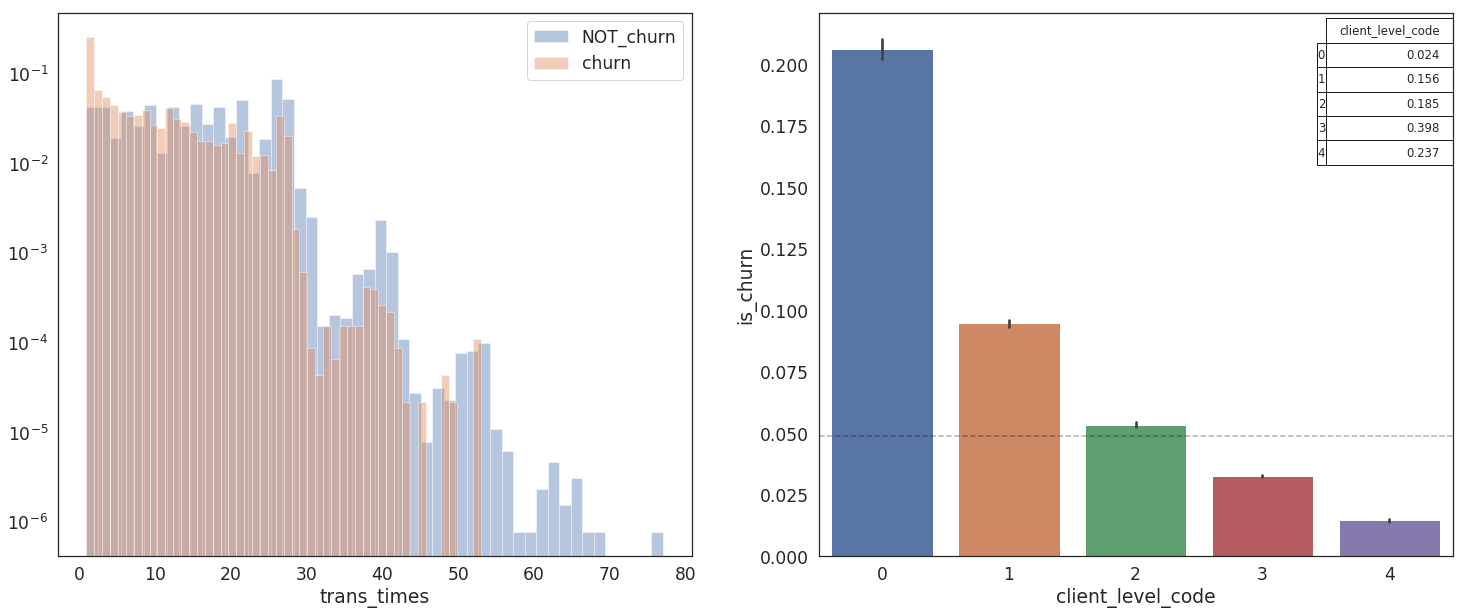

In [57]:
df_data = df_train.append(df_sub)
sns.set(font_scale=1.56)
# create fig and ax 
with sns.axes_style('white'):

  fig, [ax1, ax2] = plt.subplots(1,2, figsize=(25,10))
    
  sns.distplot(df_data.loc[(df_data.is_churn == 0), 'trans_times'],kde=False, label='NOT_churn',ax=ax1,norm_hist=True)
  sns.distplot(df_data.loc[(df_data.is_churn == 1), 'trans_times'],kde=False, label='churn',ax=ax1,norm_hist=True)
  ax1.legend()
  ax1.set_yscale('log')

  # feature enineering
  # New, Trying, OneYear, TwoYear, Stable
  max_trans = df_data.trans_times.max()
  bins = [0,1,6,12,24,max_trans]

  # period = nodes - 1 --> labels = np.arange(len( bins) -1 )
  df_data['client_level_code'] = pd.cut(df_data.trans_times, bins, labels= np.arange( len( bins) - 1 ) )
  df_data['client_level_code'] = df_data['client_level_code'].astype('int8')

  # prepare table (% of each value)
  df_percent = pd.DataFrame( df_data['client_level_code'].value_counts().sort_index() / len(df_data) ).round(3) 
  # barplot of churn rate
  sns.barplot(x='client_level_code',y='is_churn',data=df_data,ax=ax2)
  ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
  table(ax2, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

### Modeling

In [58]:
# split and prepare features 
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
client_level_code_fts = ll_churn_fts + ['client_level_code']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code'],
      dtype='object')


In [59]:
print('training using features: \n' ,[fts for fts in client_level_code_fts if fts not in exclude_list])
client_level_code_model_xgb, client_level_code_val_score_xgb,\
client_level_code_pred_xgb = model_training_xgb(df_train[client_level_code_fts],df_sub[client_level_code_fts])

training using features: 
 ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26', 'last_last_churn', 'client_level_code']
[0]	validation_0-logloss:0.62872	validation_1-logloss:0.628647
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.151943	validation_1-logloss:0.150517
[140]	validation_0-logloss:0.150876	validation_1-logloss:0.149757
Stopping. Best iteration:
[146]	validation_0-logloss:0.150826	validation_1-logloss:0.149736



In [60]:
client_level_code_pred_xgb.to_csv("/content/datalab/sub_client_level_code_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_client_level_code_xgb_pred.csv' 'gs://kkbox_bucket/submission/sub_client_level_code_xgb_pred.csv';

print('last_last_churn logloss val: ',0.15347)
print('last_last_churn logloss LB: ',0.12698)
print('-'*20,' + client_level_code','-'*20)
print('client_level_code log_loss val : ',0.14982)
print('client_level_code log_loss LB : ',0.12463)

Copying file:///content/datalab/sub_client_level_code_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 52.4 MiB/ 52.4 MiB]                                                
Operation completed over 1 objects/52.4 MiB.                                     
last_last_churn logloss val:  0.15347
last_last_churn logloss LB:  0.12698
--------------------  + client_level_code --------------------
client_level_code log_loss val :  0.14982
client_level_code log_loss LB :  0.12463


## Auto_renew explore

In [61]:
# since cumsum does not support ascending = False, we resort our data with mem_expire_date first
# need to fix sort_problem
df_train_trans = df_train_trans.sort_values(by=['msno'],ascending=False).sort_values(by=['mem_expire_date'],ascending=True)
# apply function groupby.cumsum()
df_train_trans['auto_renew_so_far'] = df_train_trans.groupby(by=['msno'],as_index=False)['is_auto_renew'].cumsum()
# resort with latest expire_date first
df_train_trans.sort_values(by=['msno','mem_expire_date'],ascending=False,inplace=True);
# since cumcount start at 0, we plus one for adjusting
df_train_trans['trans_times_so_far'] = df_train_trans.groupby(by=['msno'],as_index=False)['is_auto_renew'].cumcount(ascending=False) + 1

In [94]:
agg_result = df_train_trans.groupby(by=['msno'],as_index=False).head(1)
agg_result.eval('ratio_auto_renew = auto_renew_so_far / trans_times_so_far', inplace=True);
agg_result.head()

/usr/local/envs/py3env/lib/python3.5/site-packages/pandas/core/computation/eval.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  target[parsed_expr.assigner] = ret


,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,trans_date,mem_expire_date,is_cancel,membership,membership_int,plan_days_td,auto_renew_so_far,trans_times_so_far,ratio_auto_renew
13027578,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,0,40,30,149,149,1,2017-02-05,2017-03-04,0,27 days,27.000,30 days,1,1,1.000
573940,zzxqpgPX1epGyR3SVRKb3XitWdt+JqDURxV5ea1D7Cg=,1,38,30,149,149,0,2017-01-27,2017-03-01,0,33 days,33.000,30 days,0,21,0.000
10882430,zzxi7n5xoTYo9Q3VTygLWvl/rBDcexwaeAry0yK7Q0E=,0,41,30,99,99,1,2017-02-18,2017-03-18,0,28 days,28.000,30 days,4,4,1.000
6707336,zzxZeMFx2fjfKZigMnJa2w0EmloDbm8+8nTf/o/00GY=,0,41,30,99,99,1,2017-02-26,2017-03-26,0,28 days,28.000,30 days,26,26,1.000
4973492,zzx4hKiyR9XFEGAr7SAjcCPbKJCZ+IqegWL7dPjPwZk=,0,41,30,99,99,1,2017-02-18,2017-03-19,0,29 days,29.000,30 days,27,27,1.000


ratio of All auto_renew:0.808
ratio of All manual_renew:0.109
ratio of Mix manual&auto renew:0.084
All_auto_renew churn_rate: 0.013
All_manual_renew churn_rate: 0.287


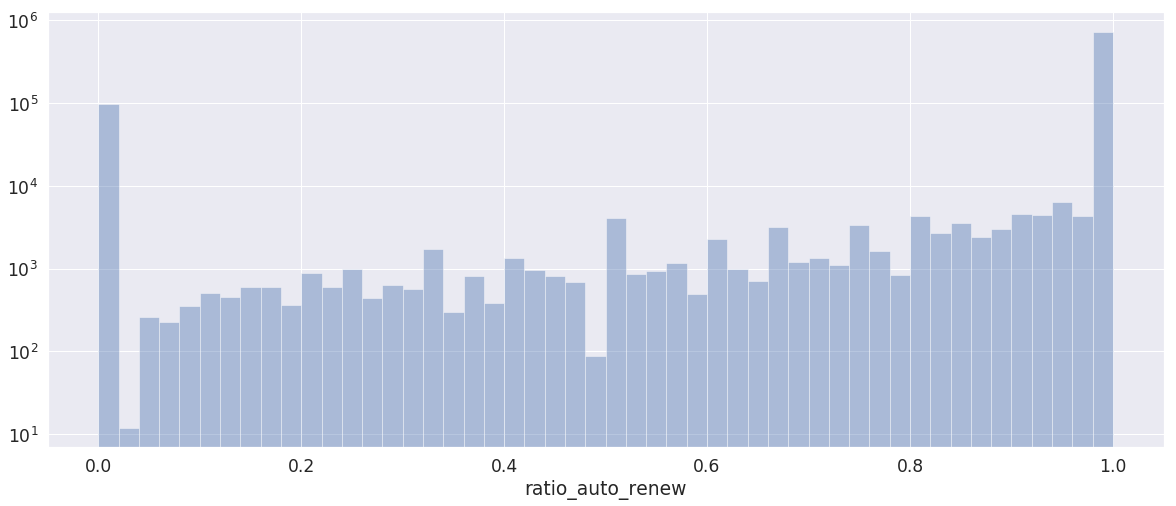

In [96]:
fig, ax = plt.subplots(figsize=(20,8))
sns.distplot(agg_result.ratio_auto_renew,kde=False,ax=ax)
ax.set_yscale('log')
print('ratio of All auto_renew:%.3f'%((agg_result.ratio_auto_renew == 1 ).sum() / len(agg_result)))
print('ratio of All manual_renew:%.3f'%((agg_result.ratio_auto_renew == 0 ).sum() / len(agg_result)))
print('ratio of Mix manual&auto renew:%.3f'%(( (agg_result.ratio_auto_renew < 1) & (agg_result.ratio_auto_renew > 0) ).sum() / len(agg_result)))
print('All_auto_renew churn_rate: %.3f' %(agg_result.query('ratio_auto_renew == 1').is_churn.mean()) )
print('All_manual_renew churn_rate: %.3f' %(agg_result.query('ratio_auto_renew == 0').is_churn.mean()) )

## Last_auto_renew

In [97]:
# Feature Engineering
# for safe, sorted first
df_train_trans = df_train_trans.sort_values(by=['msno','mem_expire_date'],ascending=False)
df_sub_trans = df_sub_trans.sort_values(by=['msno','mem_expire_date'],ascending=False)
ft_last_auto_renew_train = df_train_trans[['msno','is_auto_renew']].groupby(by=['msno'],as_index=False).head(1)
ft_last_auto_renew_sub = df_sub_trans[['msno','is_auto_renew']].groupby(by=['msno'],as_index=False).head(1)
# feature rename
ft_last_auto_renew_train.rename(columns={'is_auto_renew':'last_auto_renew'}, inplace=True)
ft_last_auto_renew_sub.rename(columns={'is_auto_renew':'last_auto_renew'}, inplace=True)

In [98]:
df_train = pd.merge(df_train,ft_last_auto_renew_train,how='left',on=['msno'])
df_sub = pd.merge(df_sub,ft_last_auto_renew_sub,how='left',on=['msno'])

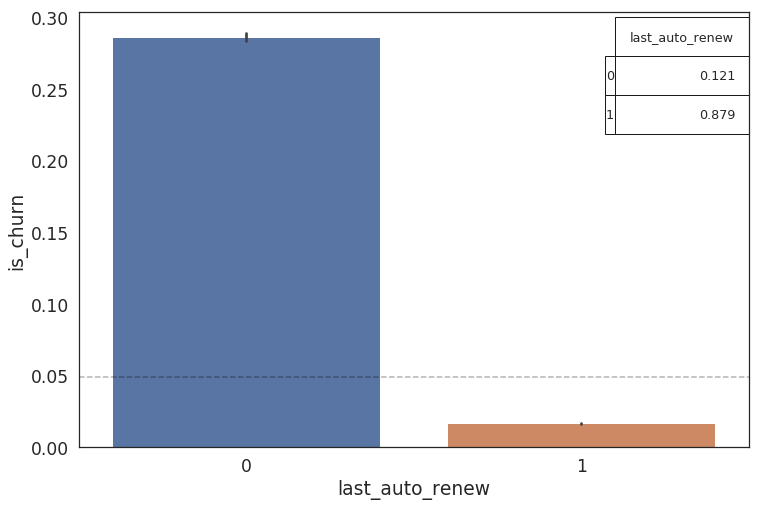

In [99]:
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize= (12,8) )
# prepare table (% of each value)
  df_percent = pd.DataFrame( df_train['last_auto_renew'].value_counts().sort_index() / len(df_train) ).round(3) 
# barplot with percent table
  sns.barplot(x='last_auto_renew',y='is_churn',data=df_train,ax=ax)
  ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
  table(ax, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

### Modeling

In [100]:
# split and prepare features 
print(df_train.columns)
print(df_sub.columns)
last_auto_renew_fts = client_level_code_fts + ['last_auto_renew']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code',
       'last_auto_renew'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code',
       'last_auto_renew'],
      dtype='object')


In [101]:
print('training using features: \n' ,[fts for fts in last_auto_renew_fts if fts not in exclude_list])
last_auto_renew_model_xgb, last_auto_renew_val_score_xgb,\
last_auto_renew_pred_xgb = model_training_xgb(df_train[last_auto_renew_fts],df_sub[last_auto_renew_fts])

training using features: 
 ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26', 'last_last_churn', 'client_level_code', 'last_auto_renew']
[0]	validation_0-logloss:0.627527	validation_1-logloss:0.627466
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[70]	validation_0-logloss:0.13594	validation_1-logloss:0.135133
[140]	validation_0-logloss:0.135099	validation_1-logloss:0.134675
[210]	validation_0-logloss:0.134703	validation_1-logloss:0.134647
Stopping. Best iteration:
[191]	validation_0-logloss:0.134792	validation_1-logloss:0.134633



In [102]:
last_auto_renew_pred_xgb.to_csv("/content/datalab/sub_last_auto_renew_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_last_auto_renew_xgb_pred.csv' 'gs://kkbox_bucket/submission/sub_last_auto_renew_xgb_pred.csv';

print('client_level_code logloss val: ',0.14982)
print('client_level_code logloss LB: ',0.12463)
print('-'*20,' + last_auto_renew','-'*20)
print('last_auto_renew log_loss val : ',0.13419)
print('last_auto_renew log_loss LB : ',0.11617)

Copying file:///content/datalab/sub_last_auto_renew_xgb_pred.csv [Content-Type=text/csv]...
- [1 files][ 52.6 MiB/ 52.6 MiB]                                                
Operation completed over 1 objects/52.6 MiB.                                     
client_level_code logloss val:  0.14982
client_level_code logloss LB:  0.12463
--------------------  + last_auto_renew --------------------
last_auto_renew log_loss val :  0.13419
last_auto_renew log_loss LB :  0.11617


## One_month_day_listen

In [106]:
%bq query -n query
-- one_month_day_listen CTE
WITH features AS (
                   SELECT  msno AS msno , COUNT(msno) AS one_month_day_listen
                   FROM `dark-garden-296106.kkbox_bucket.user_logs`
                   WHERE date > 20170201 AND date < 20170228 
                   GROUP BY msno)
SELECT train.msno, features.one_month_day_listen
FROM `dark-garden-296106.kkbox_bucket.user_label2` AS train
LEFT JOIN features 
        ON   train.msno = features.msno 

In [107]:
%bq dryrun -q query

In [108]:
%bq extract -f csv -H -p 'gs://kkbox_bucket/ft_one_month_day_listen.csv' -q query --verbose

Job dark-garden-296106/job_Xlx-n69HDdPbYm37Z_ZmVD237LEh completed

In [109]:
%bq query -n query
WITH features AS (
                   SELECT  msno AS msno , COUNT(msno) AS one_month_day_listen
                   FROM `dark-garden-296106.kkbox_bucket.user_logs`
                   WHERE date > 20170301 AND date < 20170331 
                   GROUP BY msno)
SELECT sub.msno, features.one_month_day_listen
FROM `dark-garden-296106.kkbox_bucket.submission` AS sub
LEFT JOIN features 
        ON   sub.msno = features.msno 

In [110]:
%bq dryrun -q query

In [111]:
%bq extract -f csv -H -p 'gs://kkbox_bucket/sub_ft_one_month_day_listen.csv' -q query --verbose

Job dark-garden-296106/job_8gLvysu7ms7WRENnc1_XAq-aNtxD completed

In [112]:
%gcs read --object gs://kkbox_bucket/ft_one_month_day_listen.csv -v df_one_month_day_listen

In [113]:
%gcs read --object gs://kkbox_bucket/sub_ft_one_month_day_listen.csv -v df_sub_ft_one_month_day_listen

In [114]:
ft_train_one_month_day_listen = pd.read_csv(StringIO(df_one_month_day_listen))
ft_sub_one_month_day_listen = pd.read_csv(StringIO(df_sub_ft_one_month_day_listen))

In [115]:
df_train = pd.merge(df_train, ft_train_one_month_day_listen, how='left',on=['msno'])
df_sub = pd.merge(df_sub, ft_sub_one_month_day_listen, how='left',on=['msno'])

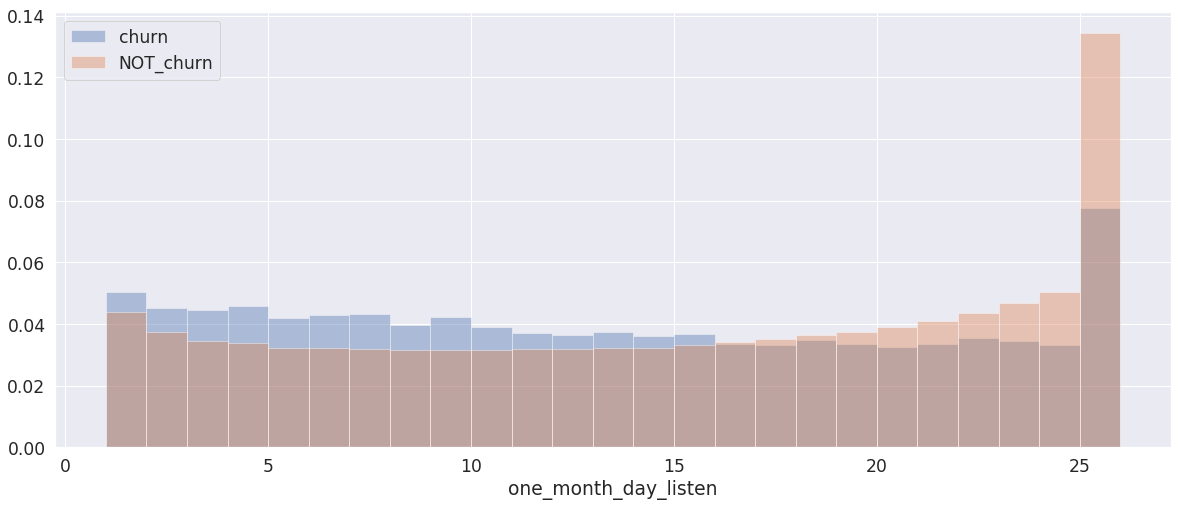

In [116]:
df_train['one_month_day_listen'] = df_train['one_month_day_listen'].fillna(-1)
df_sub['one_month_day_listen'] = df_sub['one_month_day_listen'].fillna(-1)
fig, ax = plt.subplots( figsize=(20,8) )
churn = (df_train['one_month_day_listen'] > 0) & (df_train.is_churn == 1)
NOT_churn = (df_train['one_month_day_listen'] > 0) & (df_train.is_churn == 0)
bins=25
sns.distplot(df_train.loc[churn,'one_month_day_listen'],kde=False,norm_hist=True,label='churn',ax=ax,bins=bins)
sns.distplot(df_train.loc[NOT_churn,'one_month_day_listen'],kde=False,norm_hist=True,label='NOT_churn',ax=ax,bins=bins)
ax.legend()

### Modeling

In [117]:
print(df_train.columns)
print(df_sub.columns)
one_month_day_listen_fts = last_auto_renew_fts + ['one_month_day_listen']
exclude_list = ['msno','is_churn']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code',
       'last_auto_renew', 'one_month_day_listen'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time',
       'age_under_26', 'last_last_churn', 'trans_times', 'client_level_code',
       'last_auto_renew', 'one_month_day_listen'],
      dtype='object')


In [118]:
def model_training_xgb(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # model
  xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=4,n_estimators=3,\
                 subsample=0.5, seed=2,missing=-1)
  model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [120]:
print('training using features: \n' ,[fts for fts in one_month_day_listen_fts if fts not in exclude_list])
one_month_day_listen_model_xgb, one_month_day_listen_val_score_xgb,\
one_month_day_listen_pred_xgb = model_training_xgb(df_train[one_month_day_listen_fts],df_sub[one_month_day_listen_fts])

training using features: 
 ['six_month_day_listen', 'six_month_satis', 'registered_via', 'age_under_26', 'last_last_churn', 'client_level_code', 'last_auto_renew', 'one_month_day_listen']
[0]	validation_0-logloss:0.627348	validation_1-logloss:0.627281
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.


In [123]:
one_month_day_listen_pred_xgb.to_csv("/content/datalab/sub_one_month_day_listen_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_one_month_day_listen_xgb_pred.csv' 'gs://kkbox_bucket/submission/sub_one_month_day_listen_xgb_pred.csv';

print('last_auto_renew logloss val: ',0.13419)
print('last_auto_renew logloss LB: ',0.11617)
print('-'*20,' + one_month_day_listen','-'*20)
print('one_month_day_listen log_loss val : ',0.13215)
print('one_month_day_listen log_loss LB : ',0.11335)

Copying file:///content/datalab/sub_one_month_day_listen_xgb_pred.csv [Content-Type=text/csv]...
\ [1 files][ 51.4 MiB/ 51.4 MiB]                                                
Operation completed over 1 objects/51.4 MiB.                                     
last_auto_renew logloss val:  0.13419
last_auto_renew logloss LB:  0.11617
--------------------  + one_month_day_listen --------------------
one_month_day_listen log_loss val :  0.13215
one_month_day_listen log_loss LB :  0.11335


In [124]:
# save processed data
X = df_train[one_month_day_listen_fts].drop(labels=['msno','is_churn'],axis=1)
Y = df_train[one_month_day_listen_fts]['is_churn']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
X_train.reset_index(drop=True).to_csv('X_train.csv', index=False)
pd.DataFrame({'is_churn':Y_train}).reset_index(drop=True).to_csv('Y_train.csv', index=False)
X_val.reset_index(drop=True).to_csv('X_val.csv',index=False)
pd.DataFrame({'is_churn':Y_val}).reset_index(drop=True).to_csv('Y_val.csv',index=False)